<center>
<img src="https://habrastorage.org/web/677/8e1/337/6778e1337c3d4b159d7e99df94227cb2.jpg"/>
## Специализация "Машинное обучение и анализ данных"
<center>Автор материала: программист-исследователь Mail.Ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ [Юрий Кашницкий](https://yorko.github.io/)

# <center>  Capstone проект №1 <br> Идентификация пользователей по посещенным веб-страницам
<img src='http://i.istockimg.com/file_thumbview_approve/21546327/5/stock-illustration-21546327-identification-de-l-utilisateur.jpg'>

# <center>Неделя 3. Визуальный анализ данных и построение признаков

На 3 неделе мы займемся визуальным анализом данных и построением признаков. Сначала мы вместе построим и проанализируем несколько признаков, потом Вы сможете сами придумать и описать различные признаки. 

**План 3 недели:**
 - Часть 1. Построение признаков
 - Часть 2. Визуальный анализ данных
 - Часть 3. Дальнейшее построение признаков
 - Часть 4. Проверка построенных признаков

**В этой части проекта Вам могут быть полезны видеозаписи следующих лекций курса "Поиск структуры в данных":**
   - [Задача визуализации](https://www.coursera.org/learn/unsupervised-learning/lecture/hlvlT/zadacha-vizualizatsii)
   - [Визуализация данных в sklearn](https://www.coursera.org/learn/unsupervised-learning/lecture/ityMo/vizualizatsiia-dannykh-v-sklearn)
   
**Также в задании будет использоваться библиотека Seaborn (ее можно дополнительно установить командой *pip install seaborn*), будет полезно обращаться к документациям [Matplotlib](http://matplotlib.org/users/) и [Seaborn](http://seaborn.pydata.org/), а также к примерам визуализации, описанным на StackOverflow.**



### Задание
1. Заполните код в этой тетрадке 
2. Если вы проходите специализацию Яндеса и МФТИ, пошлите тетрадку в соответствующем Peer Review. <br> Если вы проходите курс ODS, выберите ответы в [веб-форме](https://docs.google.com/forms/d/1EbjK7-hF-Gepi6RH-K5I2XeiYGRoY0LNDx03QmLu9Xo). 

## Часть 1. Построение признаков

In [1]:
1+1

2

In [7]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
from glob import glob
import itertools
import os
from tqdm import tqdm
import numpy as np
import re
import pandas as pd
pd.set_option('display.max.columns', 25)
import pickle
#pip install seaborn
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt

In [8]:
# Поменяйте на свой путь к данным
PATH_TO_DATA = r'C:\Users\1\projects\ipynb\coursera\project\week3\capstone_user_identification'

**Создайте на основе функций *prepare_train_set* и *prepare_sparse_train_set_window*  новую – *prepare_train_set_with_fe*, (от "feature engineering"), создайте следующие признаки:**
- `session_timespan` – продолжительность сессии (разница между максимальным и минимальным временем посещения сайтов в сессии, в секундах)
- `#unique_sites` – число уникальных сайтов в сессии 
- `start_hour` – час начала сессии (то есть час в записи минимального timestamp среди десяти)
- `day_of_week` – день недели (то есть день недели в записи минимального timestamp среди десяти)

Функция должна возвращать новый DataFrame (как возвращала функция *prepare_train_set*), только признаков должно быть на 4 больше. Порядок, в котором добавляются признаки: *site1*, ... *site10*, *session_timespan*, *#unique_sites*, *start_hour*, *day_of_week* и *user_id* (это видно и чуть ниже по тому, как функция вызывается).

In [15]:
def get_list(N, session_length=10, window_size=10):
        r_b = lambda x: x+session_length
        slice_list=[(i,r_b(i) if r_b(i)<N else N) for i in range(0,N,window_size)]
        return slice_list

def prepare_train_set_with_fe(path_to_csv_files, site_freq_path,feature_names, 
                                    session_length=10, window_size=10):
    
    pat = re.compile("user([\d]+)[.]")
    list_sites=[]
    list_users = []
    
    sites = ["site{}".format(i) for i in range(1,11)]
    times = ['time{0}'.format(i) for i in range(1,11)]
    names_=zip(times,sites)
    names=list(itertools.chain(*names_))
    
    unique = lambda x: len(set(x))-1 if 0 in x else len(set(x))
        
    with open(site_freq_path,"rb") as f:
        site_freq = pickle.load(f)

    for u_id,f in tqdm(enumerate(sorted(glob(path_to_csv_files+'/*')))):
        user_data = pd.read_csv(f)
        
        user_data.site=user_data.site.apply(lambda x: site_freq[x][0])
        slice_list = get_list(user_data.shape[0],session_length,window_size)
        
        list_users += [int(re.search(pat,f).group(1))] * len(slice_list)
        list_sites += [user_data.values[ind[0]:ind[1]].reshape(-1) for ind in slice_list]
        
    
    df = pd.DataFrame(list_sites,columns = names)
    df[times]=df[times].apply(pd.to_datetime)
    df[sites]=df[sites].fillna(0).astype(int)
    
    time_df = pd.DataFrame(index=df.index)
    time_df['max'] = df[times].max(axis=1)
    time_df['min'] = df[times].min(axis=1)
    time_df['seconds'] = (time_df['max'] - time_df['min']) / np.timedelta64(1, 's')
     
    df['#unique_sites']=[unique(i) for i in df[sites].values]
    
    df['start_hour'] = time_df['min'].apply(lambda x: x.hour)
    df['day_of_week'] = time_df['min'].apply(lambda x: x.dayofweek)
    df['session_timespan']=time_df['seconds']
    df['user_id'] = list_users
    
    list_feat = ['site' + str(i) for i in range(1,11)] + \
                ['session_timespan', '#unique_sites', 'start_hour', 
                 'day_of_week', 'user_id']
    df = df[list_feat]
    df.columns = feature_names

    return df

**Проверим функцию на игрушечном примере.**

In [11]:
feature_names = ['site' + str(i) for i in range(1,11)] + \
                ['session_timespan', '#unique_sites', 'start_hour', 
                 'day_of_week', 'user_id']
train_data_toy  = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, 
                                                         '3users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_3users.pkl'),
                  feature_names=feature_names, session_length=10)

3it [00:00, 427.31it/s]


In [12]:
train_data_toy

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,session_timespan,#unique_sites,start_hour,day_of_week,user_id
0,3,2,2,9,2,1,11,5,10,7,7998.0,8,9,4,1
1,3,1,1,1,0,0,0,0,0,0,60.0,2,12,4,1
2,3,2,6,6,2,0,0,0,0,0,7935.0,3,9,4,2
3,4,1,2,1,2,1,1,5,8,4,7998.0,5,9,4,3
4,4,1,2,0,0,0,0,0,0,0,1471.0,3,12,4,3


**Примените функцию *prepare_train_set_with_fe* к данным по 10 пользователям, укажите *session_length*=10.**

In [13]:
%%time
feature_names = ['site' + str(i) for i in range(1,11)] + \
                ['session_timespan', '#unique_sites', 'start_hour', 
                 'day_of_week', 'user_id']
train_data_10users  = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, 
                                                         '10users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_10users.pkl'),
                  feature_names=feature_names, session_length=10)

10it [00:05,  1.80it/s]


Wall time: 6.26 s


In [14]:
train_data_10users.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,session_timespan,#unique_sites,start_hour,day_of_week,user_id
0,192,586,133,3,133,133,3,133,203,133,33.0,5,8,4,31
1,424,193,693,254,133,31,401,4303,219,55,284.0,10,8,4,31
2,55,3,55,55,5,294,424,339,898,55,258.0,7,8,4,31
3,480,3358,480,55,55,55,55,958,201,123,30.0,6,8,4,31
4,342,55,5,3695,261,212,4513,2136,677,2136,6.0,9,8,4,31


**Примените функцию *prepare_train_set_with_fe* к данным по 150 пользователям, укажите *session_length*=10.**

In [16]:
%%time
feature_names = ['site' + str(i) for i in range(1,11)] + \
                ['session_timespan', '#unique_sites', 'start_hour', 
                 'day_of_week', 'user_id']
train_data_150usersa  = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, 
                                                         '150users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_150users.pkl'),
                  feature_names=feature_names, session_length=10)

150it [00:53,  4.97it/s]


Wall time: 57.2 s


**Сохраните в pickle-файлы признаки *session_timespan*, *#unique_sites*, *start_hour* и *day_of_week* для 10 и 150 пользователей.**

In [17]:
new_features_10users = train_data_10users[['session_timespan', '#unique_sites', 'start_hour', 
                 'day_of_week']]
new_features_150users = train_data_150usersa[['session_timespan', '#unique_sites', 'start_hour', 
                 'day_of_week', 'user_id']]

In [18]:
with open(os.path.join(PATH_TO_DATA, 
                       'new_features_10users.pkl'), 'wb') as new_features_10users_pkl:
    pickle.dump(new_features_10users, new_features_10users_pkl)
with open(os.path.join(PATH_TO_DATA, 
                       'new_features_150users.pkl'), 'wb') as new_features_150users_pkl:
    pickle.dump(new_features_150users, new_features_150users_pkl)

**<font color='red'>Вопрос 1. </font> Выведите медианную продолжительность сессии (*session_timespan*) для сессий 10 пользователей.**

In [19]:
train_data_10users['session_timespan'].median()

37.0

**<font color='red'>Вопрос 2. </font> Выведите медианный день недели, в который началась сессия, для сессий 10 пользователей.**

In [20]:
train_data_10users['day_of_week'].median()

2.0

**<font color='red'>Вопрос 3. </font>Выведите медианный час начала сессии для сессий 150 пользователей.**

In [21]:
new_features_150users['start_hour'].median()

13.0

**<font color='red'>Вопрос 4. </font>Выведите медианное значение числа уникальных сайтов в сессиях 150 пользователей.**

In [22]:
new_features_150users['#unique_sites'].median()

7.0

## Часть 2. Визуальный анализ данных

**Забавы ради, потехи для дадим пользователям имена и ассоциируем с ними цвета.**

In [24]:
id_name_dict = {128: 'Mary-Kate', 39: 'Ashley', 207: 'Lindsey', 127: 'Naomi', 237: 'Avril',
               33: 'Bob', 50: 'Bill', 31: 'John', 100: 'Dick', 241: 'Ed'}
train_data_10users['target'] = train_data_10users['user_id'].map(id_name_dict)

In [25]:
color_dic = {'Mary-Kate': 'pink', 'Ashley': 'darkviolet', 'Lindsey':'blueviolet', 
             'Naomi': 'hotpink', 'Avril': 'orchid', 
             'Bob': 'firebrick', 'Bill': 'gold', 'John': 'forestgreen', 
             'Dick': 'slategrey', 'Ed':'brown'}

**1. Постройте гистограмму распределения длины сессии в секундах (*session_timespan*). Ограничьте по *x* значением 200 (иначе слишком тяжелый хвост). Сделайте гистограмму цвета *darkviolet*, подпишите оси по-русски.**

In [28]:
x=train_data_10users['session_timespan']
x_less_2= x[x<200]

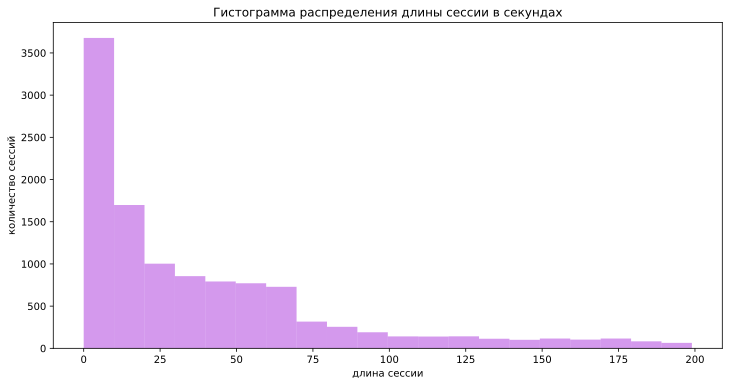

In [157]:
%config InlineBackend.figure_format = 'svg' 
plt.figure(figsize=(12,6))
hist_sess=sns.distplot(x_less_2,bins=20,kde=False,color='darkviolet')
hist_sess.set(xlabel='длина сессии',ylabel='количество сессий')
plt.title('Гистограмма распределения длины сессии в секундах')
plt.savefig("length_session_dist.svg")
plt.show()

**2. Постройте гистограмму распределения числа уникальных сайтов в сессии (*#unique_sites*). Сделайте гистограмму цвета *aqua*, подпишите оси по-русски.**

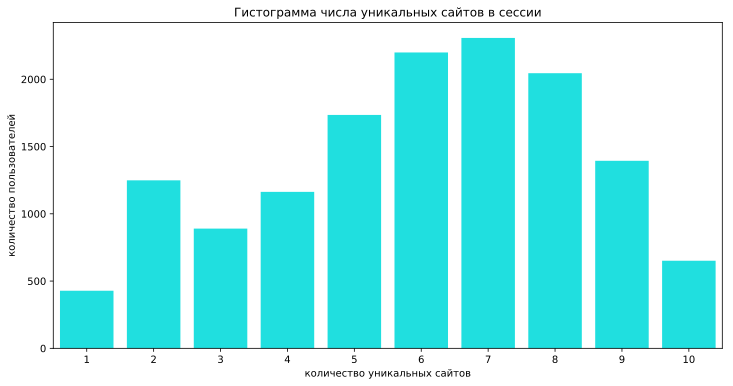

In [156]:
unique_sites_data=train_data_10users['#unique_sites']
value_count=unique_sites_data.value_counts()
plt.figure(figsize=(12,6))
hist_sess=sns.countplot(unique_sites_data,color='aqua')
hist_sess.set(xlabel='количество уникальных сайтов', ylabel='количество пользователей')
plt.title('Гистограмма числа уникальных сайтов в сессии')
plt.savefig("num_unique_sites.svg")
plt.show()

**3. Постройте гистограммы распределения числа уникальных сайтов в сессии (*#unique_sites*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите оси по-русски в каждой из 10 гистограмм.**

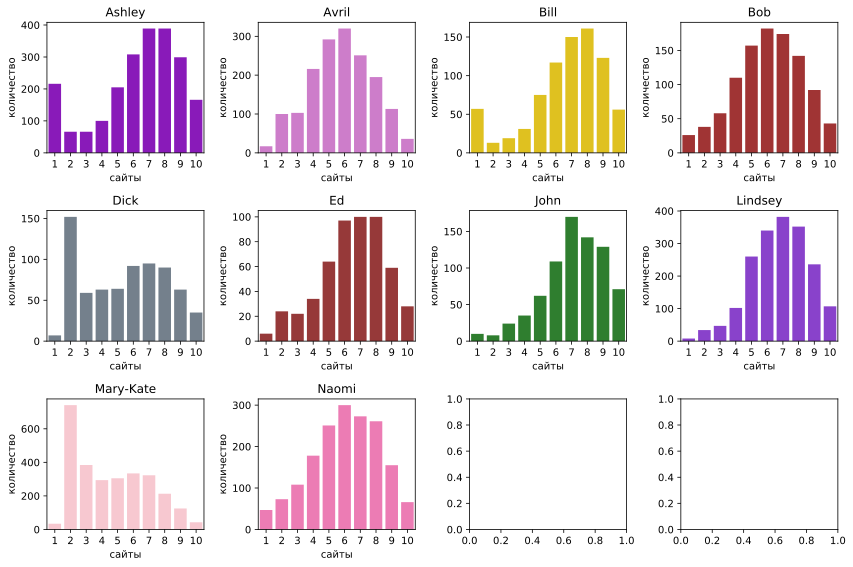

In [155]:
d={key:val['#unique_sites'] for (key,val) in train_data_10users[['#unique_sites','target']].groupby(['target'])}

fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(12,8))
for numb,(name,val) in enumerate(d.items()):
    hist_sess=sns.countplot(val,color=color_dic[name], ax=axes[numb // 4, numb % 4])
    hist_sess.set_title(name)
    hist_sess.set(xlabel='сайты',ylabel='количество')
fig.tight_layout()

# plt.show()
plt.savefig("uniq_hist_user.svg")
plt.show()

**4. Постройте гистограмму распределения часа начала сессии (*start_hour*). Сделайте гистограмму цвета *darkgreen*, подпишите оси по-русски.**

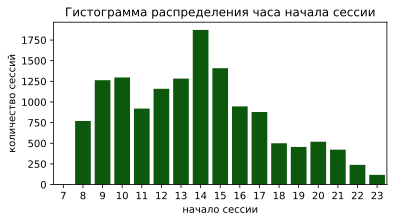

In [154]:
plt.figure(figsize=(6,3))
hist_sess=sns.countplot(train_data_10users['start_hour'],color='darkgreen')
hist_sess.set(xlabel='начало сессии', ylabel='количество сессий')
plt.title('Гистограмма распределения часа начала сессии')

#plt.show()
plt.savefig("start_hour_hits.svg")
plt.show()

**5. Постройте гистограммы распределения часа начала сессии (*start_hour*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите оси по-русски в каждой из 10 гистограмм.**

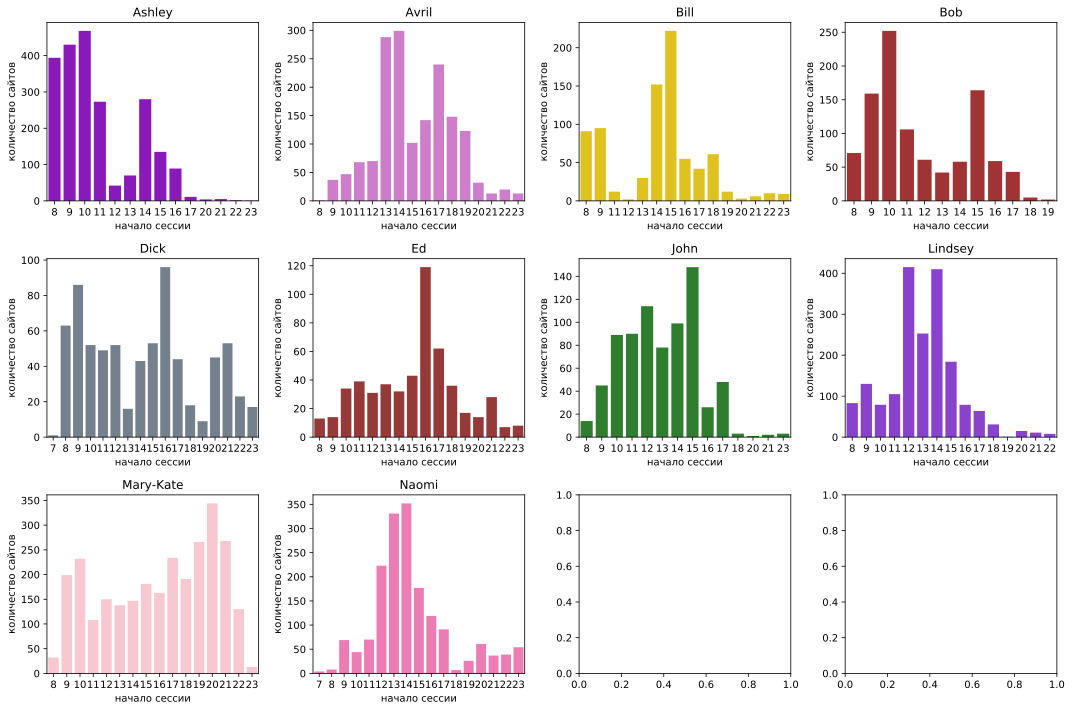

In [153]:
d={key:val['start_hour'] for (key,val) in train_data_10users[['start_hour','target']].groupby(['target'])}

fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(15,10))
for numb,(name,val) in enumerate(d.items()):
    hist_sess=sns.countplot(val,color=color_dic[name], ax=axes[numb // 4, numb % 4])
    hist_sess.set_title(name)
    hist_sess.set(xlabel='начало сессии', ylabel='количество сайтов')
fig.tight_layout()

plt.savefig("start_hour_users.svg")
plt.show()

**6. Постройте гистограмму распределения дня недели, в который началась сессия (*day_of_week*). Сделайте гистограмму цвета *sienna*, подпишите оси по-русски.**

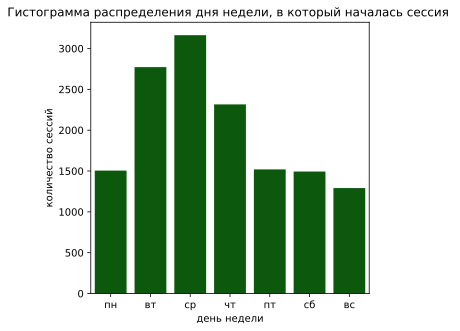

In [152]:
data=train_data_10users['day_of_week']
plt.figure(figsize=(5,5))
day_of_week = ['пн','вт','ср','чт','пт','сб','вс']

hist_sess=sns.countplot(data,color='darkgreen')
hist_sess.set(xlabel='день недели', ylabel='количество сессий')
plt.title('Гистограмма распределения дня недели, в который началась сессия ')

plt.xticks(range(7),day_of_week)
plt.savefig("day_of_week.svg")
plt.show()

**7. Постройте гистограммы распределения дня недели, в который началась сессия (*day_of_week*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Измените метки по оси *X* на ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'] – метод *set_xticklabels*. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите по-русски название каждой из 10 гистограмм.**

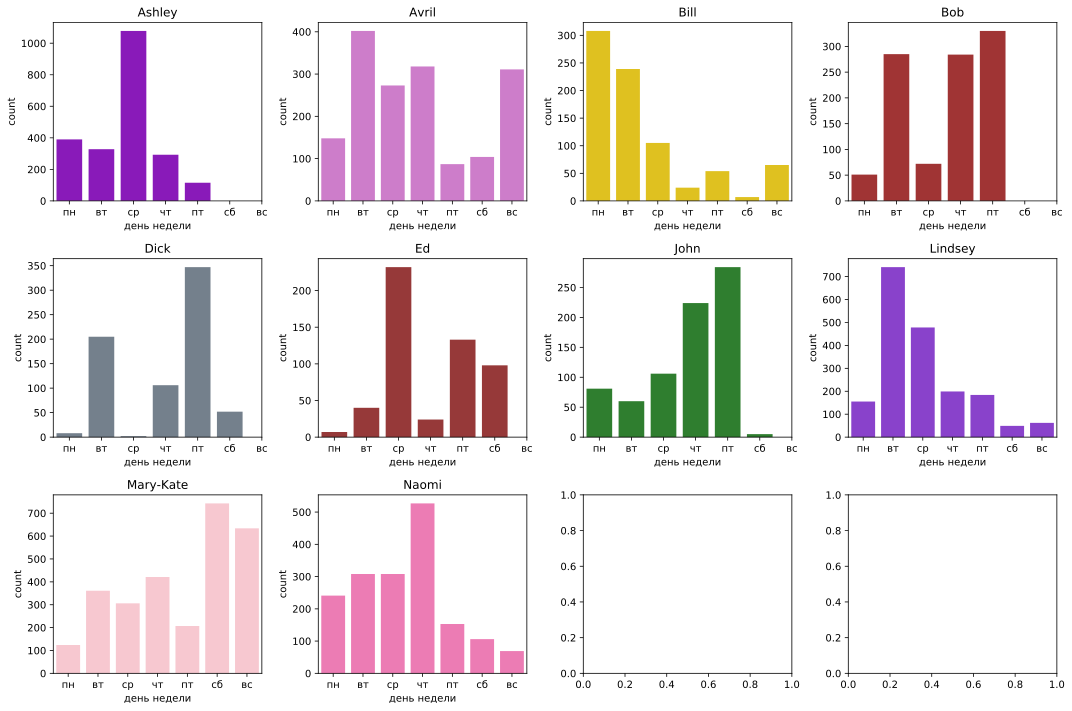

In [71]:
d={key:val['day_of_week'] for (key,val) in train_data_10users[['day_of_week','target']].groupby(['target'])}

fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10,6))
for numb,(name,val) in enumerate(d.items()):
    hist_sess=sns.countplot(val,color=color_dic[name], ax=axes[numb // 4, numb % 4])
    hist_sess.set_title(name)
    hist_sess.set(xlabel='день недели')
    plt.sca(axes[numb // 4, numb % 4])
    plt.xticks(range(7),day_of_week)

    fig.tight_layout()
plt.savefig("day_of_week_users.svg")

**8. Сделайте выводы про каждого пользователя по построенным графикам.**

#### Длина сессии
* Чем меньше длина сессии, тем больше таких сессий

#### различные сайты:
* Большинство пользователей посещают похожее количество разичных сайтов в сессии преобладает 6-8 сайтов, за ислключением Dick и Mary-Kate, у них преобладает 1 сайт.

#### начало сессии:
* Общий пик начала сессии приходится на 14-00 (как бы это не было обедом на работе)
* Ashley,Bob в основном заходят на сайты утром, Avril,Bill, Ed, Lindsey,Naomi - днем, Mary-Kate вечером, остальные пользователи утром и днем.

#### день недели:
* Ashley в основном посещает сайты в среду
* Avril в пн-чт и вс в чт и пт она менее активна
* Bill в основном посещает сайты в начале недели 
* Bob во вт, чт, пт, в выходные дни он неактивен
* Dic находится в интернете во вт, пт, в воскресенье и среду он неактивен
* Ed В освновном посещает сайты с ср, пт, сб, в воскресенье он неактивен
* John наиболее активен в чт,пт в выходные дни он неактивен
* Lindsey наиболее активна во вт, ср, на выходных слабая активность
* Mary-Kate в среднем активна всю неделю, но наиболее активна на выходных
* Naomi активна по будням и в чт активность - максимальна, в выходные дни она мало активна.

**Загрузите сохраненный ранее в pickle-файл частотный словарь сайтов для 10 пользователей. **

In [73]:
with open(PATH_TO_DATA+'/site_freq_10users.pkl','rb') as f:
    site_freq_10 = pickle.load(f)

df_freq = pd.DataFrame(data=list(site_freq_10.values()),index=list(site_freq_10.keys()),\
                                                        columns = ['index_site','count'])

df_freq=df_freq.sort_values(by='count',ascending=False,kind='mergesort')

**Определите топ-10 самых посещаемых сайтов (*top10_sites*) и соответствующие кол-ва посещений (*top10_freqs*).**

In [74]:
top10_freqs = df_freq.head(10)['count'].values
top10_sites = df_freq.head(10)['count'].index

In [75]:
df_freq.head(10)['count']

s.youtube.com                           8300
www.google.fr                           7813
www.google.com                          5441
mail.google.com                         4158
www.facebook.com                        4141
apis.google.com                         3758
r3---sn-gxo5uxg-jqbe.googlevideo.com    3244
r1---sn-gxo5uxg-jqbe.googlevideo.com    3094
plus.google.com                         2630
accounts.google.com                     2089
Name: count, dtype: int64

**9. Нарисуйте *seaborn barplot*, показывающий частоты посещений топ-10 сайтов. Сделайте подписи сайтов вертикальными, иначе они сливаются (*xticks*).**

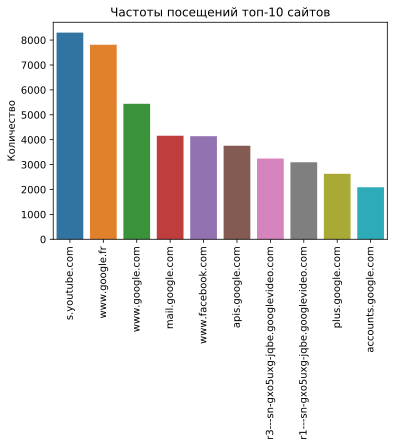

In [80]:
fig=sns.barplot(x=df_freq.head(10).index,y='count',data=df_freq.head(10))
plt.xticks(rotation='vertical')
plt.title('Частоты посещений топ-10 сайтов')
plt.ylabel('Количество')
plt.show()

## Часть 3. Дальнейшее построение признаков

Это задание творческое, тут надо придумать, как еще учесть время посещения веб-страниц и прочие признаки. 

На следующей неделе мы будем использовать "мешок" сайтов  для классификации сессий по принадлежности разным пользователям, а эти новые признаки, которые Вы сейчас создадите, потом добавим и посмотрим, улучшается ли модель. Поэтому можно их создать в виде отдельных матриц и сохранить их также отдельно.  

В этой части задания Вы можете построить и визуально исследовать самые разные признаки (ничто фантазию не ограничивает):
- год, месяц и день начала сессии
- час начала сессии (с учетом года, месяца и дня)
- время суток
- среднее время пребывания на сайте, посчитать можно, скажем, для топ-30 популярных сайтов
- индикаторы посещения популярных сайтов (скажем, тоже для топ-30 популярных сайтов)
- частота посещения Facebook
- ...

**Напишите функцию для создания новых признаков и примените ее к исходным данным – каталогам с 10 и 150 файлами. Сделайте это только для набора данных, полученного с параметрами *session_length=10* и *window_size=10*. Сериализуйте полученные матрицы с помощью pickle. Функция может возвращать как только новые признаки, так и старые с новыми. При этом сигнатура функции может быть другой – тут уже свобода выбора.**

Рассмотрим следующие признаки:
- время суток начала сессии
- среднее время пребывания на сайте
- частота посещения Facebook

In [83]:
from scipy.sparse import csr_matrix

In [84]:
def time_of_day(hour):
    if 0 <= hour < 6:
        return 0
    elif 6 <= hour < 13:
        return 1
    elif 13 <= hour < 19:
        return 2
    elif 19 <= hour < 24:
        return 3
def calc_stay_time(time):
    arr_time=(time.values[1:]-time.values[:-1])/np.timedelta64(1, 's')
    gt_hour_ind = np.argwhere(arr_time>3600)
    ind_less_hour=np.setdiff1d(np.arange(len(arr_time)),gt_hour_ind)
    mean=np.mean(arr_time[ind_less_hour])
    arr_time[gt_hour_ind]=mean
    arr_time = np.append(arr_time,[mean])
    return arr_time

In [107]:
def feature_engineering(path_to_csv_files,site_freq_path,\
                        window_size=10, session_length=10,top_sites=31):
    """
    sparce_matrix
    """
    indptr = [0]
    count = 0
    indices = []
    value_matrix = []

    """
    new_features
    """
    mean_time = []
    t_of_day_list = []
    n_of_visits_fb = []

    pat = re.compile("user([\d]+)[.]")
    list_users=[]

    with open(site_freq_path,"rb") as f:
        site_freq = pickle.load(f)
        
    n_fb = site_freq['www.facebook.com'][0]
    for u_id,f in tqdm(enumerate(sorted(glob(path_to_csv_files+'/*')))):

        user_data = pd.read_csv(f)
        
        user_data.site=user_data.site.apply(lambda x: site_freq[x][0])
        slice_list = get_list(user_data.shape[0],session_length,window_size)
        
        list_users += [int(re.search(pat,f).group(1))] * len(slice_list)
        user_data = pd.read_csv(f)
        user_data.timestamp=user_data.timestamp.apply(pd.to_datetime)

        user_data['stay_time']=calc_stay_time(user_data.timestamp)        
        

        user_data.site=user_data.site.apply(lambda x: site_freq[x][0])

        for ind in slice_list:
            data = user_data.iloc[ind[0]:ind[1]]
            t_of_day_list.append(time_of_day(data.timestamp.min().hour))
            indx_ = np.in1d(data.site,range(1,top_sites+1))
            try:
                n_of_visits_fb.append(data.site.value_counts()[n_fb])
            except KeyError:
                n_of_visits_fb.append(0)
                
            data = data[indx_]
           
            
            counter = data.site.unique().tolist()
            count += len(counter)
            indptr.append(count)
            indices += counter
            value_matrix += len(counter)*[1]

            mean_time.append(data.stay_time.mean())

    return pd.DataFrame({'user_id': list_users, 'mean_time':mean_time,'time_of_day':t_of_day_list,'fb_count':n_of_visits_fb, }),\
           csr_matrix( (value_matrix,indices,indptr),\
                      shape=(len(t_of_day_list),top_sites+1) )[:,1:]

In [108]:
path_to_csv_files=os.path.join(PATH_TO_DATA,'10users') 
site_freq_path=os.path.join(PATH_TO_DATA,'site_freq_10users.pkl')

new_features_10users = feature_engineering(path_to_csv_files,site_freq_path)

10it [00:20,  1.93s/it]


In [88]:
path_to_csv_files=os.path.join(PATH_TO_DATA,'150users') 
site_freq_path=os.path.join(PATH_TO_DATA,'site_freq_150users.pkl')

new_features_150users = feature_engineering(path_to_csv_files,site_freq_path) 

100%|██████████| 150/150 [03:13<00:00,  1.04s/it]


**10. Постройте картинки для новых признаков, поисследуйте их, прокомментируйте результаты.**

In [109]:
A = new_features_10users[1]
feat_eng = new_features_10users[0]

In [110]:
feat_eng.head(1)

,user_id,mean_time,time_of_day,fb_count
0,31,0.5,1,0


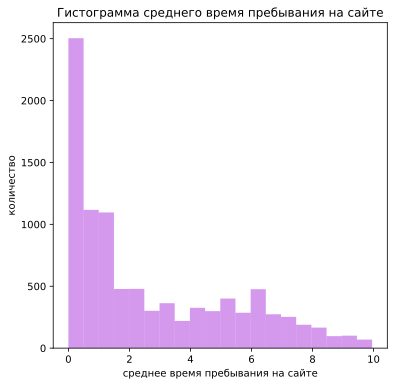

In [117]:
plt.figure(figsize=(6,6))
hist_sess=sns.distplot(feat_eng.mean_time[feat_eng.mean_time<10],bins=20,kde=False,color='darkviolet')
hist_sess.set(xlabel='среднее время пребывания на сайте',ylabel='количество')
plt.title('Гистограмма среднего время пребывания на сайте')
plt.show()

Сделано с обрезкой для уменьшения хвоста

In [120]:
id_name_dict = {128: 'Mary-Kate', 39: 'Ashley', 207: 'Lindsey', 127: 'Naomi', 237: 'Avril',
               33: 'Bob', 50: 'Bill', 31: 'John', 100: 'Dick', 241: 'Ed'}
feat_eng['target'] = feat_eng['user_id'].map(id_name_dict)

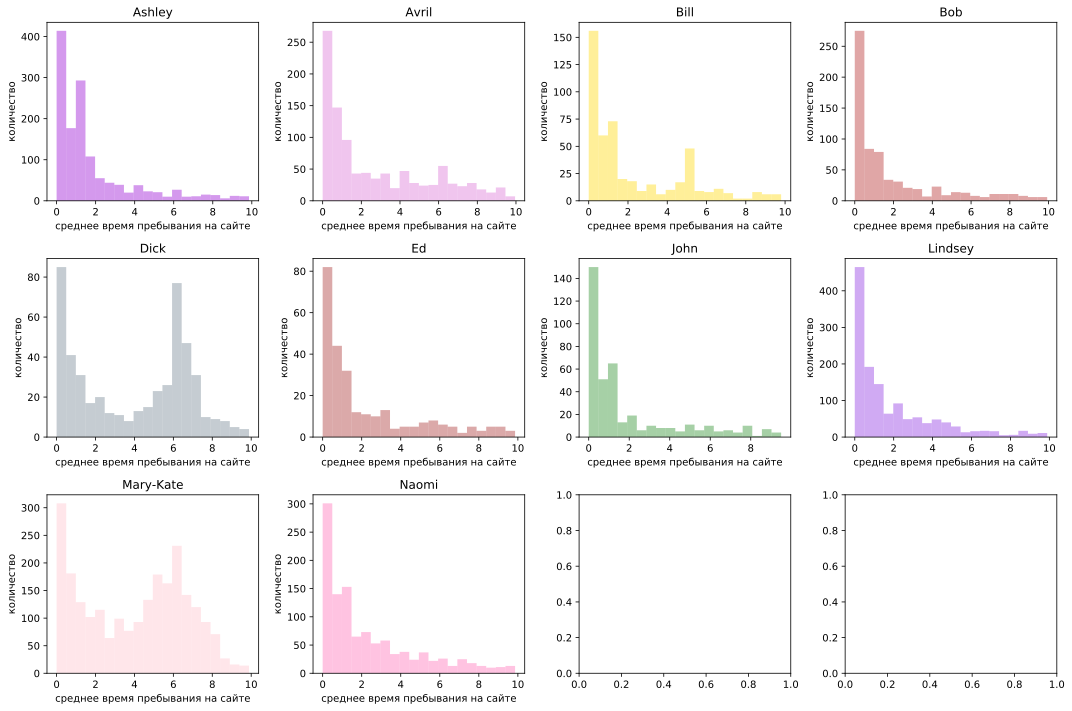

In [151]:
d={key:val['mean_time'] for (key,val) in feat_eng[['mean_time','target']].groupby(['target'])}

fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(15,10))
for numb,(name,val) in enumerate(d.items()):
    hist_sess=sns.distplot(val[val<10],color=color_dic[name], ax=axes[numb // 4, numb % 4], bins=20,kde=False,)
    hist_sess.set_title(name)
    hist_sess.set(xlabel='среднее время пребывания на сайте',ylabel='количество')

    fig.tight_layout()
plt.savefig("mean_time_users.svg")
plt.show()

В принципе для пользователей паттерн присутствует

Сделано с обрезкой для уменьшения хвоста

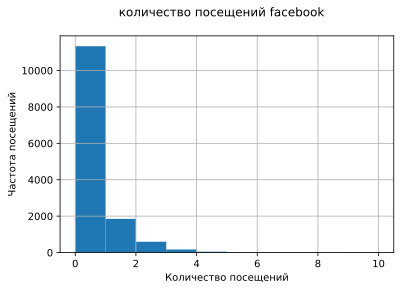

In [150]:
plot=feat_eng.fb_count.hist()
plt.suptitle('количество посещений facebook')
plt.savefig("my_feat2.svg")
plt.xlabel('Количество посещений')
plt.ylabel('Частота посещений')
plt.show()

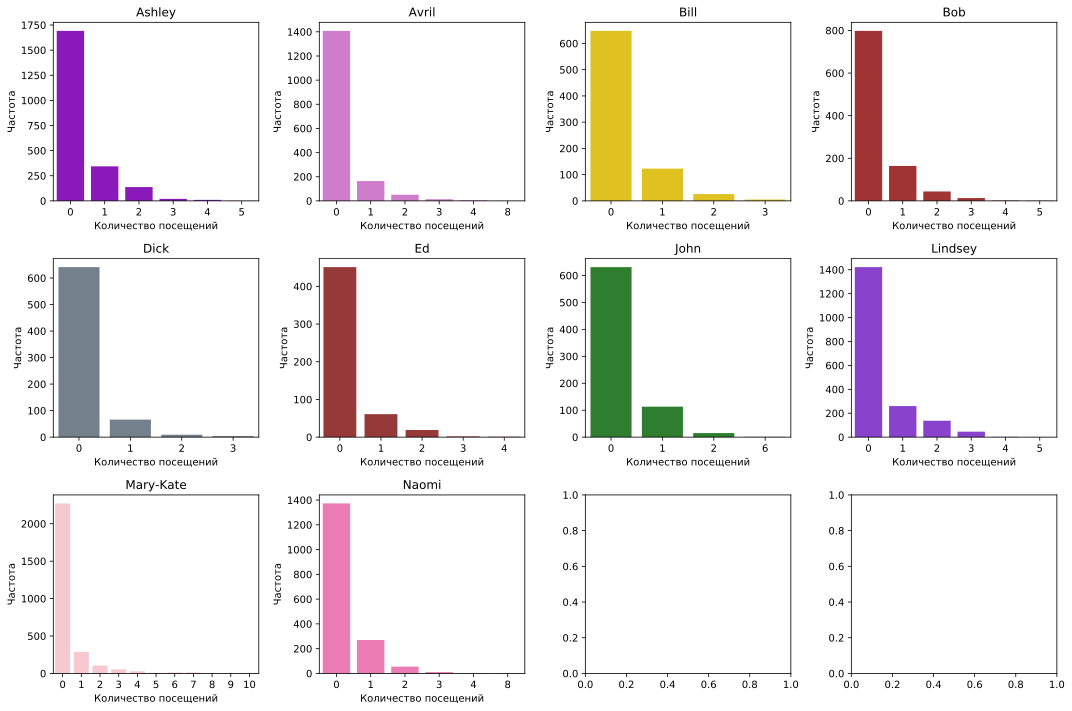

In [149]:
d={key:val['fb_count'] for (key,val) in feat_eng[['fb_count','target']].groupby(['target'])}

fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(15,10))
for numb,(name,val) in enumerate(d.items()):
    hist_sess=sns.countplot(val,color=color_dic[name], ax=axes[numb // 4, numb % 4])
    hist_sess.set_title(name)
    hist_sess.set(xlabel='Количество посещений',ylabel='Частота')

    fig.tight_layout()
plt.savefig("mean_time_users.svg")
plt.show()

Паттерн менее явный

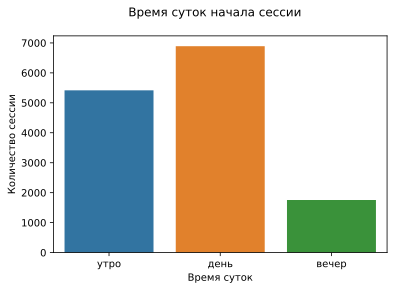

In [148]:
sns.countplot(feat_eng.time_of_day)
plt.xticks(range(3),['утро','день','вечер'])
plt.savefig("my_feat3.svg")
# plt.show()
plt.suptitle('Время суток начала сессии')
plt.savefig("my_feat2.svg")
plt.xlabel('Время суток')
plt.ylabel('Количество сессии')
plt.show()

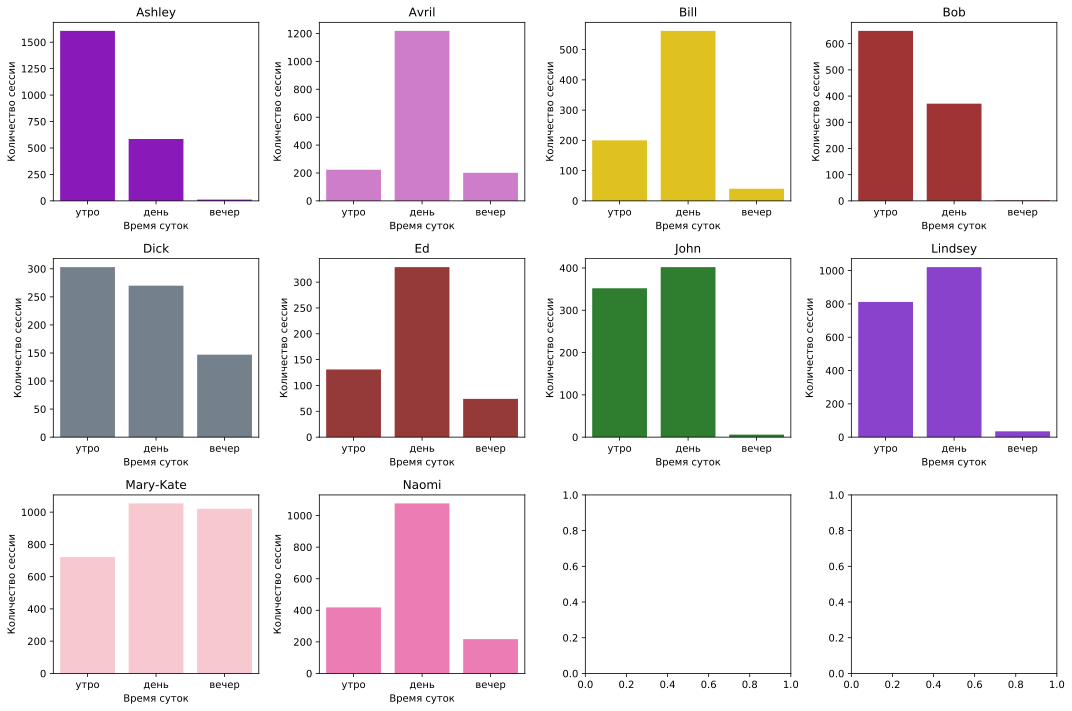

In [147]:
d={key:val['time_of_day'] for (key,val) in feat_eng[['time_of_day','target']].groupby(['target'])}

fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(15,10))
for numb,(name,val) in enumerate(d.items()):
    hist_sess=sns.countplot(val,color=color_dic[name], ax=axes[numb // 4, numb % 4])
    plt.sca(axes[numb // 4, numb % 4])

    plt.xticks(range(3),['утро','день','вечер'])
    hist_sess.set_title(name)
    hist_sess.set(xlabel='Время суток',ylabel='Количество сессии')

fig.tight_layout()
plt.savefig("time_of_day.svg")
plt.show()

Паттер есть и можно воспользоваться

**В конце сохраните в pickle-файлы только те признаки, которые, как Вы предполагаете, помогут идентифицировать пользователя более точно. Это касается и признаков, которые мы вместе создали в начале (*session_timespan, #unique_sites, start_hour, day_of_week*), и Ваших собственных. Можно создать все эти признаки не только для сессий из 10 сайтов, но и для других сочетаний параметров *session_length* и *window_size*.**

In [145]:
selected_features_10users = feat_eng[['time_of_day', 'mean_time']]
selected_features_150users = new_features_150users[0][['time_of_day', 'mean_time']]

In [146]:
with open(os.path.join(PATH_TO_DATA, 
                       'selected_features_10users.pkl'), 'wb') as selected_features_10users_pkl:
    pickle.dump(selected_features_10users, selected_features_10users_pkl, 
                protocol=2)
with open(os.path.join(PATH_TO_DATA, 
                       'selected_features_150users.pkl'), 'wb') as selected_features_150users_pkl:
    pickle.dump(selected_features_150users, selected_features_150users_pkl, 
                protocol=2)

### Критерии оценки работы (только для Peer Review в специализации):
- Верно ли отображена гистограмма session_timespan из п. 1? (max. 3 балла)
- Верно ли отображена гистограмма #unique_sites из п. 2? (max. 3 балла)
- Верно ли отображены гистограммы #unique_sites по каждому пользователю из п. 3? (max. 6 баллов)
- Верно ли отображена гистограмма start_hour из п. 4? (max. 3 балла)
- Верно ли отображены гистограммы start_hour по каждому пользователю из п. 5? (max. 6 баллов)
- Верно ли отображена гистограмма day_of_week из п. 6? (max. 3 балла)
- Верно ли отображены гистограммы day_of_week по каждому пользователю из п. 7? (max. 6 баллов)
- Насколько сделанные выводы в п. 8 соответствуют построенным картинкам? (max. 6 баллов)
- Верно ли отображен barplot для 10 популярных сайтов из п. 9? (max. 6 баллов)
- Правильно ли посчитана медианная продолжительность сессий в п. 10? (max. 3 балла)
- Правильно ли посчитан медианный день недели начала сессии в п. 11? (max. 3 балла)
- Правильно ли посчитан медианный час начала сессии в п. 12? (max. 3 балла)
- Правильно ли посчитано медианное значение числа уникальных сайтов в сессиях 150 пользователей п. 13? (max. 3 балла)
- Есть ли оригинальные построенные признаки и картинки к ним? Оцените также и качество картинок. (max. 8 баллов)

## Пути улучшения
Что еще можно добавить по 3 части проекта:
- IPython-widgets, интерактив и анимация (стоящие статьи по этому ремеслу – [раз](https://habrahabr.ru/post/308162/) и  [два](https://habrahabr.ru/company/ods/blog/323210/))
- можно попробовать изобразить исходные данные в некотором пространстве, например, Word2Vec, потом выделить главные компоненты или t-SNE  (только пользуйтесь эффективными реализациями типа [Multicore-TSNE](https://github.com/DmitryUlyanov/Multicore-TSNE), не Sklearn) и раскрасить по целевому классу. Но нет гарантий, что получится что-то значимо отличающееся от каши

На следующей неделе мы наконец приступим к обучению моделей классификации. 